In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import random
import shutil
import math
import keras
import cv2
import tensorflow as tf
import pathlib
import torch
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import scipy.io
import torchvision.transforms as transforms
from PIL import Image
from keras.models import Sequential
from keras import Input, Model
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.callbacks import History
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [3]:
IMAGES_PATH = "/content/drive/MyDrive/Machine Learning/labeled"
UNLABELED_IMGS_PATH = "/content/drive/MyDrive/Machine Learning/jpg"
PATH_GRAPHS = "/content/drive/MyDrive/Machine Learning/graphs"
RELU = "relu"
SOFTMAX = "softmax"
CAT_CROSS_EN = "categorical_crossentropy"
ACC = "accuracy"
TRAIN_VAL_SPLIT = 1 / 3
NUM_CATEGORIES = 102

mat = scipy.io.loadmat('/content/drive/MyDrive/Machine Learning/imagelabels.mat')

labels = mat['labels'][0]

# make vgg untrainable
VGG = VGG19(include_top=False, classes=102, weights="imagenet")
for layer in VGG.layers:
  layer.trainable = False

DENSE_UNITS = [128]
BATCH_SIZES = [32, 64]
EPOCHS = [50]
INPUT_SIZE = [224]

# Data Preperation

In [ ]:
def create_labeled_data():
    """
    This function
    """
    img_id = 1
    for l in mat['labels'][0]:
        num_zeroes = math.ceil(4 - math.log10(img_id))
        path = UNLABELED_IMGS_PATH + '/image_' + '0' * num_zeroes + '{}.jpg'.format(img_id)

        img = cv2.imread(path)
        if img is None:
          break

        dir_p = IMAGES_PATH + '/label_' + str(l)
        filename = dir_p + '/image_' + '0' * num_zeroes + '{}.jpg'.format(img_id)

        if not os.path.exists(dir_p):
            Path(dir_p).mkdir(exist_ok=True, parents=True)

        cv2.imwrite(filename, img)

        img_id += 1
#create_labeled_data()

In [ ]:
# Set the paths and proportions
folder_path = UNLABELED_IMGS_PATH  # Update with the actual path to the "jpg" folder
train_prop = 0.5
test_prop = 0.25
val_prop = 0.25

X_train, X_val, X_test = [[], []], [[], []], [[], []]
y_train, y_val, y_test = [[], []], [[], []], [[], []]

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.25, random_state=42)

# Get a list of image filenames
image_files = np.array([file for file in os.listdir(folder_path) if file.endswith(".jpg")])
num_images = len(image_files)

for i, (train_index, test_index) in enumerate(sss.split(image_files, labels)):
    # Create directories for train, test, and validation splits
    train_dir = f"./datasets/data{i + 1}/train"
    test_dir = f"./datasets/data{i + 1}/test"
    val_dir = f"./datasets/data{i + 1}/validation"

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    train_files = image_files[train_index]
    test_files = image_files[test_index]

    trainSSS = StratifiedShuffleSplit(n_splits=1, test_size=1 / 3, random_state=42)
    final_train_idx, final_val_idx = next(trainSSS.split(train_files, labels[train_index]))

    train_files = image_files[final_train_idx]
    val_files = image_files[final_val_idx]

    # Save the split.
    X_train[i] = train_files
    X_val[i] = val_files
    X_test[i] = test_files

In [5]:
y_train, y_val, y_test = [[], []], [[], []], [[], []]

# define the labels of the images.

for i in [0, 1]:
    for file in X_train[i]:
          img_num = int(file.split(".")[0].split("_")[1])
          y_train[i].append(labels[img_num - 1])
    for file in X_val[i]:
        img_num = int(file.split(".")[0].split("_")[1])
        y_val[i].append(labels[img_num - 1])
    for file in X_test[i]:
        img_num = int(file.split(".")[0].split("_")[1])
        y_test[i].append(labels[img_num - 1])

In [ ]:
import pickle

with open('/content/drive/MyDrive/Machine Learning/X_train', mode='wb') as f:
    pickle.dump(X_train, f)
with open('/content/drive/MyDrive/Machine Learning/X_val', mode='wb') as f:
    pickle.dump(X_val, f)
with open('/content/drive/MyDrive/Machine Learning/X_test', mode='wb') as f:
    pickle.dump(X_test, f)
with open('/content/drive/MyDrive/Machine Learning/y_train', mode='wb') as f:
    pickle.dump(y_train, f)
with open('/content/drive/MyDrive/Machine Learning/y_val', mode='wb') as f:
    pickle.dump(y_val, f)
with open('/content/drive/MyDrive/Machine Learning/y_test', mode='wb') as f:
    pickle.dump(y_test, f)

In [4]:
import pickle

with open("/content/drive/MyDrive/Machine Learning/X_train", mode='rb') as f:
  X_train = pickle.load(f)
with open("/content/drive/MyDrive/Machine Learning/X_val", mode='rb') as f:
  X_val = pickle.load(f)
with open("/content/drive/MyDrive/Machine Learning/X_test", mode='rb') as f:
  X_test = pickle.load(f)
with open("/content/drive/MyDrive/Machine Learning/y_train", mode='rb') as f:
  y_train = pickle.load(f)
with open("/content/drive/MyDrive/Machine Learning/y_val", mode='rb') as f:
  y_val = pickle.load(f)
with open("/content/drive/MyDrive/Machine Learning/y_test", mode='rb') as f:
  y_test = pickle.load(f)

In [ ]:
def copy_files(src_folder, dst_folder):
    os.makedirs(dst_folder[:-1], exist_ok=True)

    # Fetching the list of all the files
    files = os.listdir(src_folder)

    # Fetching all the files to directory
    for file_name in files:
      shutil.copy(src_folder+file_name, dst_folder+file_name)

In [6]:
def one_hot_encode_labels(labels):
    encoded_labels = []
    for label in labels:
        encoded_label = np.zeros(NUM_CATEGORIES)
        encoded_label[label - 1] = 1
        encoded_labels.append(encoded_label)

    return np.array(encoded_labels)


def preprocess(size, imgs_names):
    """pre preprocessing for VGG19.
       the images are converted from RGB to BGR and each channel is zero-centered with respect to the pixel’s values distribution in the ImageNet dataset, without scaling.
    """
    images = []
    for img_file in imgs_names:
        # load an image from file
        image = load_img(UNLABELED_IMGS_PATH + "/" + img_file, target_size=(size, size))

        # convert the image pixels to a numpy array
        image = img_to_array(image)

        # reshape data for the model
        image = image.reshape((image.shape[0], image.shape[1], image.shape[2]))

        # prepare the image for the VGG model
        image = preprocess_input(image)

        images.append(image)

    return np.array(images)

In [7]:
label_train1, label_train2 = one_hot_encode_labels(y_train[0]), one_hot_encode_labels(y_train[1])
label_val1, label_val2 = one_hot_encode_labels(y_val[0]), one_hot_encode_labels(y_val[1])
label_test1, label_test2 = one_hot_encode_labels(y_test[0]), one_hot_encode_labels(y_test[1])

In [ ]:
size = 224

img_train1, img_train2 = preprocess(size, X_train[0]), preprocess(size, X_train[1])
img_val1, img_val2 = preprocess(size, X_val[0]), preprocess(size, X_val[1])
img_test1, img_test2 = preprocess(size, X_test[0]), preprocess(size, X_test[1])

In [8]:
#1. transform images to tensors.
size = 320

def prepare_YOLO_input(images_paths):
  # pre process for yolo, convert to torch tensor and resize the image.
  image_tensors = []
  transform = transforms.Compose([transforms.Resize((size, size)),transforms.ToTensor()])
  for img_file in images_paths:
    image_path = UNLABELED_IMGS_PATH + "/" + img_file
    image = Image.open(image_path)
    image_tensor = transform(image)
    image_tensor = image_tensor.unsqueeze(0)
    image_tensors.append(image_tensor)

  image_tensor = torch.stack(image_tensors, dim=0)
  return image_tensor

# VGG Transfer Learning

In [ ]:
def create_VGG_classifier(input_size, dense_units, lr=0.001, dropout_proba=0.0):
    inp = Input((input_size, input_size, 3))

    vgg_res = VGG(inp)

    flat = Flatten()(vgg_res)

    dense = Dense(dense_units, activation='relu')(flat)

    dense = Dense(dense_units / 2, activation='relu')(dense)

    dropout = Dropout(dropout_proba)(dense)

    output = Dense(NUM_CATEGORIES, activation='softmax')(dropout)

    model = Model(inp, output)

    model.compile(optimizer=Adam(lr), loss=CAT_CROSS_EN, metrics=[ACC])

    return model

In [ ]:
def run_VGG():
    results = pd.DataFrame(columns=["input size", "batch size", "epochs", "dense units", "dropout proba",
                                    "train loss 1", "train loss 2", "train acc 1", "train acc 2",
                                    "val loss 1", "val loss 2", "val acc 1", "val acc 2",
                                    "test loss 1", "test loss 2", "test acc 1", "test acc 2"])
    cnt = 16
    for input_size in INPUT_SIZE:
        for batch_size in [64]:
            for dense_units in [512]:
                for epochs in [25]:
                    for dropout_proba in [0.2]:
                        result = dict()
                        result["input size"] = input_size
                        result["batch size"] = batch_size
                        result["epochs"] = epochs
                        result["dense units"] = dense_units
                        result["dropout proba"] = dropout_proba

                        model = create_VGG_classifier(input_size, dense_units, dropout_proba=dropout_proba)

                        history1 = History()
                        history1 = model.fit(img_train1, label_train1, batch_size=batch_size,
                                            validation_data=[img_val1, label_val1], callbacks=[history1], epochs=epochs)

                        test_loss1, test_acc1 = model.evaluate(img_test1, label_test1)

                        result["train loss 1"] = history1.history['loss'][-1]
                        result["train acc 1"] = history1.history['accuracy'][-1]
                        result["val loss 1"] = history1.history['val_loss'][-1]
                        result["val acc 1"] = history1.history['val_accuracy'][-1]
                        result["test loss 1"] = test_loss1
                        result["test acc 1"] = test_acc1

                        loss_acc_graphs(history1, f"split1_{input_size}_{batch_size}_{epochs}_{dense_units}_{dropout_proba}")

                        model = create_VGG_classifier(input_size, dense_units, dropout_proba=dropout_proba)

                        history2 = History()
                        history2 = model.fit(img_train2, label_train2, batch_size=batch_size,
                                            validation_data=[img_val2, label_val2], callbacks=[history2], epochs=epochs)

                        test_loss2, test_acc2 = model.evaluate(img_test2, label_test2)

                        result["train loss 2"] = history2.history['loss'][-1]
                        result["train acc 2"] = history2.history['accuracy'][-1]
                        result["val loss 2"] = history2.history['val_loss'][-1]
                        result["val acc 2"] = history2.history['val_accuracy'][-1]
                        result["test loss 2"] = test_loss2
                        result["test acc 2"] = test_acc2

                        loss_acc_graphs(history2, f"split2_{input_size}_{batch_size}_{epochs}_{dense_units}_{dropout_proba}")

                        loss_acc_graphs(history1, f"avg_{input_size}_{batch_size}_{epochs}_{dense_units}_{dropout_proba}", log2=history2)

                        result_df = pd.DataFrame.from_dict(columns=results.columns, data={'0': result}, orient='index')
                        results = pd.concat([results, result_df], axis=0, ignore_index=True)
                        results.to_csv(f'/content/drive/MyDrive/Machine Learning/VGG_results{cnt}.csv')
                        cnt += 1

    results.to_csv('/content/drive/MyDrive/Machine Learning/VGG_results.csv')

In [ ]:
import matplotlib.pyplot as plt

def loss_acc_graphs(log, hyper_parameters, log2=None):
    """
    Plots the loss and accuracy using scatter plots based on the model's log.

    Args:
        log (keras.callbacks.History): The model's log.
        hyper_parameters (str): Experiment's identification through hyper-parameters
        log2 (keras.callbacks.History, optional): Additional model's log for comparison.
    """

    # Plot loss
    plt.figure()
    plt.plot(range(1, len(log.history['loss']) + 1), log.history['loss'] if log2 is None else (np.array(log.history['loss']) + np.array(log2.history['loss'])) / 2, label='train')
    plt.plot(range(1, len(log.history['val_loss']) + 1), log.history['val_loss'] if log2 is None else (np.array(log.history['val_loss']) + np.array(log2.history['val_loss'])) / 2, label='validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{PATH_GRAPHS}/loss_{hyper_parameters}.png')
    plt.close()

    # Plot accuracy
    plt.figure()
    plt.plot(range(1, len(log.history['accuracy']) + 1), log.history['accuracy'] if log2 is None else (np.array(log.history['accuracy']) + np.array(log2.history['accuracy'])) / 2, label='train')
    plt.plot(range(1, len(log.history['val_accuracy']) + 1), log.history['val_accuracy'] if log2 is None else (np.array(log.history['val_accuracy']) + np.array(log2.history['val_accuracy'])) / 2, label='validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'{PATH_GRAPHS}/accuracy_{hyper_parameters}.png')
    plt.close()

In [ ]:
run_VGG()

# YOLOv5 Transfer Learning

In [ ]:
!pip install ultralytics

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True, autoshape=False, classes=102)
model.model = model.model[:10]

In [ ]:
yolo_img_train = prepare_YOLO_input(X_train[0])
with open('/content/drive/MyDrive/Machine Learning/yolo_X_train1', mode='wb') as f:
  pickle.dump(yolo_img_train, f)

yolo_img_train = prepare_YOLO_input(X_train[1])
with open('/content/drive/MyDrive/Machine Learning/yolo_X_train2', mode='wb') as f:
  pickle.dump(yolo_img_train, f)

In [ ]:
yolo_img_val = prepare_YOLO_input(X_val[0])
with open('/content/drive/MyDrive/Machine Learning/yolo_X_val1', mode='wb') as f:
  pickle.dump(yolo_img_val, f)

yolo_img_val = prepare_YOLO_input(X_val[1])
with open('/content/drive/MyDrive/Machine Learning/yolo_X_val2', mode='wb') as f:
  pickle.dump(yolo_img_val, f)

In [ ]:
yolo_img_test = prepare_YOLO_input(X_test[0])
with open('/content/drive/MyDrive/Machine Learning/yolo_X_test1', mode='wb') as f:
  pickle.dump(yolo_img_test, f)

yolo_img_test =  prepare_YOLO_input(X_test[1])
with open('/content/drive/MyDrive/Machine Learning/yolo_X_test2', mode='wb') as f:
  pickle.dump(yolo_img_test, f)

In [11]:
def load_yolo_data(split_num):
  # load a train, val, test split into memory.
  X_train, X_val, X_test = None, None, None
  with open(f'/content/drive/MyDrive/Machine Learning/yolo_X_train{split_num}', mode='rb') as f:
    X_train = pickle.load(f)
  with open(f'/content/drive/MyDrive/Machine Learning/yolo_X_val{split_num}', mode='rb') as f:
    X_val = pickle.load(f)
  with open(f'/content/drive/MyDrive/Machine Learning/yolo_X_test{split_num}', mode='rb') as f:
    X_test = pickle.load(f)
  return X_train, X_val, X_test

In [12]:
def create_YOLO_classifier(input_size, dense_units, lr=0.001, dropout_proba=0.0):
    cls = Sequential()
    cls.add(Conv2D(dense_units / 2, kernel_size=3, strides=1, padding="same", activation="relu", input_shape=(512, 10, 10)))
    cls.add(BatchNormalization())
    cls.add(MaxPooling2D(pool_size=2, strides=2))
    cls.add(Flatten())
    cls.add(Dense(dense_units, activation="relu"))
    cls.add(Dropout(dropout_proba))
    cls.add(Dense(NUM_CATEGORIES, activation="softmax"))

    cls.compile(optimizer=Adam(lr), loss=CAT_CROSS_EN, metrics=[ACC])

    return cls

In [13]:
def calculate_acc(y_true, y_pred):
  predicted_labels = np.argmax(y_pred, axis=1)
  real_labels = np.argmax(y_true, axis=1)
  correct_pred = (predicted_labels == real_labels).sum()
  return correct_pred / len(y_true)

def split_and_shuffle(features, target, batch_size):
    """
    The function splits a dataset into batches.
    """
    # Get the number of samples
    num_samples = len(features)

    # Create random permutation of indices
    indices = np.random.permutation(num_samples)

    # Shuffle the features and target using the indices
    shuffled_features = features[indices]
    shuffled_target = target[indices]

    # Calculate the number of batches needed
    num_batches = num_samples // batch_size

    # Create a list to hold the batches
    X_batches, y_batches = [], []

    # Split the shuffled data into batches
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        batch_features = shuffled_features[start_idx:end_idx]
        batch_target = shuffled_target[start_idx:end_idx]

        # Convert TensorFlow tensors to NumPy arrays first
        batch_features_np = batch_features.numpy()
        batch_target_np = batch_target

        # Convert NumPy arrays to PyTorch tensors
        batch_features_torch = torch.tensor(batch_features_np)
        batch_target_torch = torch.tensor(batch_target_np)

        X_batches.append(batch_features_torch)
        y_batches.append(batch_target_torch)

    return X_batches, y_batches

def train_yolo_cls(epochs, batch_size, classifier, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Our own traning loop for the yolo-based classifier.
    """
    # convert to tensors for YOLO.
    X_train = torch.tensor(X_train)
    y_train = torch.tensor(y_train)
    X_val = torch.tensor(X_val)
    y_val = torch.tensor(y_val)
    X_test = torch.tensor(X_test)
    y_test = torch.tensor(y_test)

    # split to batches.
    X_batches, y_batches = split_and_shuffle(X_train, y_train, batch_size)

    losses, accuracies = [], []
    val_losses, val_accuracies = [], []

    n_batches = len(X_batches)

    optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    # the main loop.
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        epoch_loss = 0
        epoch_accuracy = 0

        # Iterate over the batches of the dataset.
        for (x_batch_train, y_batch_train) in zip(X_batches, y_batches):
            with tf.GradientTape() as tape:
                # forward pass, first apply YOLO, then apply the classifier.
                x_batch_train = torch.reshape(x_batch_train, shape=(batch_size, 3, 320, 320)).cuda()
                x_batch_train = model(x_batch_train.cuda())
                x_batch_train = x_batch_train.cpu()

                logits = classifier(x_batch_train.detach().numpy(), training=True)

                loss_value = cross_entropy(y_batch_train.numpy(), logits)
                acc = calculate_acc(y_batch_train.numpy(), logits)

                epoch_loss += loss_value
                epoch_accuracy += acc

            # back propogation.
            grads = tape.gradient(loss_value, classifier.trainable_weights)

            # Run one step of gradient descent by updating
            # the value of the variables to minimize the loss.
            optimizer.apply_gradients(zip(grads, classifier.trainable_weights))

        # loss, accuracy on train set.
        epoch_loss /= n_batches
        epoch_accuracy /= n_batches

        losses.append(epoch_loss)
        accuracies.append(epoch_accuracy)

        # split to batches.
        X_batches_val, y_batches_val = split_and_shuffle(X_val, y_val, batch_size)

        val_loss = 0
        val_acc = 0

        for (x_batch_val, y_batch_val) in zip(X_batches_val, y_batches_val):
            # forward pass, add loss and accuracy.
            x_batch_val = torch.reshape(x_batch_val, shape=(batch_size, 3, 320, 320)).cuda()
            x_batch_val = model(x_batch_val.cuda())
            x_batch_val = x_batch_val.cpu()

            logits = classifier(x_batch_val.detach().numpy(), training=False)

            val_loss += cross_entropy(y_batch_val.numpy(), logits)
            val_acc += calculate_acc(y_batch_val.numpy(), logits)

        val_loss /= len(X_batches_val)
        val_acc /= len(X_batches_val)

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"acc :{epoch_accuracy}\n")
        print(f"loss :{epoch_loss}\n")
        print(f"val acc :{val_acc}\n")
        print(f"val loss :{val_loss}\n")

    # after training is concluded, evaluate on test set.
    X_batches_test, y_batches_test = split_and_shuffle(X_test, y_test, batch_size)

    test_loss = 0
    test_acc = 0

    for (x_batch_test, y_batch_test) in zip(X_batches_test, y_batches_test):
        x_batch_test = torch.reshape(x_batch_test, shape=(batch_size, 3, 320, 320)).cuda()
        x_batch_test = model(x_batch_test.cuda())
        x_batch_test = x_batch_test.cpu()

        logits = classifier(x_batch_test.detach().numpy(), training=False)

        test_loss += cross_entropy(y_batch_test.numpy(), logits)
        test_acc += calculate_acc(y_batch_test.numpy(), logits)

    test_loss /= len(X_batches_test)
    test_acc /= len(X_batches_test)

    print(f"test loss {test_loss}, test acc {test_acc}")

    return losses, accuracies, val_losses, val_accuracies, test_loss, test_acc

In [14]:
def run_YOLO():
    results = pd.DataFrame(columns=["input size", "batch size", "epochs", "dense units", "dropout proba",
                                    "train loss 1", "train loss 2", "train acc 1", "train acc 2",
                                    "val loss 1", "val loss 2", "val acc 1", "val acc 2",
                                    "test loss 1", "test loss 2", "test acc 1", "test acc 2"])
    cnt = 111
    for input_size in [320]:
        for batch_size in [64]:
            for dense_units in [512]:
                for epochs in [5]:
                    for dropout_proba in [0.2]:
                        print(f"yolo__{input_size}_{batch_size}_{epochs}_{dense_units}_{dropout_proba}")
                        result = dict()
                        result["input size"] = input_size
                        result["batch size"] = batch_size
                        result["epochs"] = epochs
                        result["dense units"] = dense_units
                        result["dropout proba"] = dropout_proba

                        classifier = create_YOLO_classifier(input_size, dense_units, dropout_proba=dropout_proba)
                        img_train, img_val, img_test = load_yolo_data(1)

                        losses1, accuracies1, val_losses1, val_accuracies1, test_loss, test_acc = train_yolo_cls(epochs, batch_size, classifier, img_train, label_train1, img_val, label_val1, img_test, label_test1)

                        result["train loss 1"] = losses1[-1]
                        result["train acc 1"] = accuracies1[-1]
                        result["val loss 1"] = val_losses1[-1]
                        result["val acc 1"] = val_accuracies1[-1]
                        result["test loss 1"] = test_loss
                        result["test acc 1"] = test_acc

                        loss_acc_yolo_graphs(accuracies1, val_accuracies1, losses1, val_losses1, f"yolo_split1_{input_size}_{batch_size}_{epochs}_{dense_units}_{dropout_proba}")

                        classifier = create_YOLO_classifier(input_size, dense_units, dropout_proba=dropout_proba)
                        img_train, img_val, img_test = load_yolo_data(2)

                        losses2, accuracies2, val_losses2, val_accuracies2, test_loss, test_acc = train_yolo_cls(epochs, batch_size, classifier, img_train, label_train2, img_val, label_val2, img_test, label_test2)

                        result["train loss 2"] = losses2[-1]
                        result["train acc 2"] = accuracies2[-1]
                        result["val loss 2"] = val_losses2[-1]
                        result["val acc 2"] = val_accuracies2[-1]
                        result["test loss 2"] = test_loss
                        result["test acc 2"] = test_acc

                        loss_acc_yolo_graphs(accuracies2, val_accuracies2, losses2, val_losses2, f"yolo_split2_{input_size}_{batch_size}_{epochs}_{dense_units}_{dropout_proba}")

                        avg_train_accs = (np.array(accuracies1) + np.array(accuracies2)) / 2
                        avg_train_losses = (np.array(losses1) + np.array(losses2)) / 2
                        avg_val_accs = (np.array(val_accuracies1) + np.array(val_accuracies2)) / 2
                        avg_val_losses = (np.array(val_losses1) + np.array(val_losses2)) / 2

                        loss_acc_yolo_graphs(avg_train_accs, avg_val_accs, avg_train_losses, avg_val_losses, f"yolo_avg_{input_size}_{batch_size}_{epochs}_{dense_units}_{dropout_proba}")

                        result_df = pd.DataFrame.from_dict(columns=results.columns, data={'0': result}, orient='index')
                        results = pd.concat([results, result_df], axis=0, ignore_index=True)
                        results.to_csv(f'/content/drive/MyDrive/Machine Learning/YOLO_results{cnt}.csv')
                        cnt += 1

    results.to_csv('/content/drive/MyDrive/Machine Learning/YOLO_results.csv')

In [15]:
import matplotlib.pyplot as plt

def loss_acc_yolo_graphs(train_accs, val_accs, train_losses, val_losses, hyper_parameters):
    """
    Plots the loss and accuracy using scatter plots based on the model's log.

    Args:
        log (keras.callbacks.History): The model's log.
        hyper_parameters (str): Experiment's identification through hyper-parameters
        log2 (keras.callbacks.History, optional): Additional model's log for comparison.

    Returns:
        pd.DataFrame: A dataframe containing the loss and accuracy values
            of the last epoch for the training and validation sets.
    """

    # Plot loss
    plt.figure()
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='train')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{PATH_GRAPHS}/yolo_loss_{hyper_parameters}.png')
    plt.close()

    # Plot accuracy
    plt.figure()
    plt.plot(range(1, len(train_accs) + 1), train_accs, label='train')
    plt.plot(range(1, len(val_accs) + 1), val_accs, label='validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'{PATH_GRAPHS}/yolo_accuracy_{hyper_parameters}.png')
    plt.close()

In [ ]:
run_YOLO()

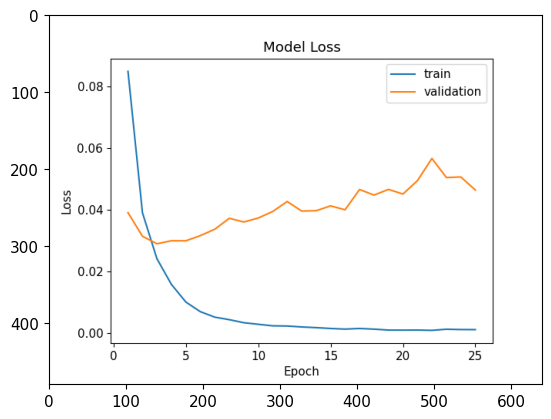

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

param_str = f"_{320}_{64}_{25}_{512}_{0.2}.png"
pref1 = "yolo_accuracy_yolo_avg"
pref2 = "yolo_loss_yolo_avg"
pref3 = "yolo_accuracy_yolo_split1"
pref4 = "yolo_loss_yolo_split1"
pref5 = "yolo_accuracy_yolo_split2"
pref6 = "yolo_loss_yolo_split2"

img = mpimg.imread(PATH_GRAPHS + "/" + pref6 + param_str)
imgplot = plt.imshow(img)
plt.show()